https://github.com/mjpyeon/wavenet-classifier/blob/master/WaveNetClassifier.py

Dataset is the raw RADAR data that has not been reshaped into chirps.

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [28]:
# Needed to allow editing using PyCharm etc
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [0]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks\\wavenet':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/wavenet/range_fft_half_total_bins_mti/'
MODEL_PATH = BASE_PATH + 'models/wavenet/range_fft/most_powerful_bin/'
    
from src.data import load_data
from src.visualization import multiple_plots, visualize, plot_confusion_matrix
from src.features import make_spectrograms, process_labels, make_directory
from src.models.dilated_CNN.wavenet import WaveNetClassifier

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import preprocessing
from keras.utils import np_utils
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from keras import metrics
from keras import optimizers
from keras.callbacks import History, ModelCheckpoint
from keras.models import load_model

In [0]:
# Load in data dictionary.
# This does not load in any actual data,
# just the dictionary with the names of the files and their associated labels
with open(DATA_PATH + "index.pkl", "rb") as file:
    data = pickle.load(file)

In [0]:
# Remove user C as this user is reserved for the test set
try:
    del data["C"]
except KeyError:
    print ("Key 'C' not found")

In [0]:
def convert_label_to_int(label):
    if label == "walking":
        return 0
    if label == "pushing":
        return 1
    if label == "sitting":
        return 2
    if label == "pulling":
        return 3
    if label == "circling":
        return 4
    if label == "clapping":
        return 5
    if label == "bending":
        return 6

In [0]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
labels = {}
partition = {'train':[], 'validation':[]} # contains list of training and validation ID's
validation_user = "F"
for user_letter, actions in data.items():
    for action, results in actions.items():
        for result in results:
            for row in result:
                if user_letter == validation_user:
                    partition["validation"].append(row)
                    labels[row] = convert_label_to_int(action)

                else:
                    partition["train"].append(row)
                    labels[row] = convert_label_to_int(action)

In [0]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(3000), n_channels=1,
                 n_classes=7, shuffle=True, data_directory='data/', data_type="training"):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.data_directory = data_directory
        self.data_type = data_type
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
#         print(self.data_type, index)
        'Generate one batch of data'
#         start_time = time.time()

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
#         time_for_getitem = (time.time() - start_time)
#         print(time_for_getitem)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
#         X = np.empty((self.batch_size, *self.dim))

        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            data = abs(np.load(self.data_directory + ID))
            most_powerful_bin_index = np.argmax(np.mean(data, axis=0))
            X[i,] = data[:, most_powerful_bin_index]
            # Store class
            y[i] = self.labels[ID]

        return X, to_categorical(y, num_classes=self.n_classes)

In [0]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)

In [0]:
data_shape = (3000,)
n_filters = 100
n_filters = 64
# n_filters = 40
dilation_depth = 8
activation = 'softmax'
scale_ratio = 1
kernel_size = 2
pool_size_1 = 4
pool_size_2 = 8
batch_size = 16
epochs = 30

In [0]:
# Parameters
params = {'dim': (data_shape[0],),
          'batch_size': batch_size,
          'n_classes': nb_classes,
          'shuffle': True,
          'data_directory': DATA_PATH}
# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params, data_type="Validation")

In [0]:
wnc = WaveNetClassifier(data_shape, (7,), kernel_size = kernel_size,
                        dilation_depth = dilation_depth, n_filters = n_filters,
                        pool_size_1=pool_size_1, pool_size_2=pool_size_2)

In [0]:
model = wnc.get_model()

In [0]:
load_weights = False
weights_path = MODEL_PATH + "epoch-08-val_acc-0.14.hdf5"

start_epoch = 0
if load_weights:
    model = load_model(weights_path)
#     model.load_weights(weights_path)
    last_epoch = weights_path.split("-")[-3]
    start_epoch = int(last_epoch)

In [0]:
if not load_weights:
    model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
checkpoint = ModelCheckpoint(MODEL_PATH + "epoch-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5",
                             monitor='val_acc', verbose=0, save_best_only=False,
                             save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]

In [47]:
# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=9,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    initial_epoch=start_epoch)

Epoch 1/30
181/181 [==============================] - 78s 434ms/step - loss: 1.8243 - acc: 0.2421 - val_loss: 1.9867 - val_acc: 0.1556

Epoch 2/30
181/181 [==============================] - 69s 382ms/step - loss: 1.6385 - acc: 0.3764 - val_loss: 5.9012 - val_acc: 0.1492
Epoch 3/30
181/181 [==============================] - 70s 389ms/step - loss: 1.1745 - acc: 0.5107 - val_loss: 6.4941 - val_acc: 0.1709
Epoch 4/30
181/181 [==============================] - 70s 387ms/step - loss: 0.9569 - acc: 0.5981 - val_loss: 6.5146 - val_acc: 0.1913
Epoch 5/30
181/181 [==============================] - 68s 378ms/step - loss: 0.7600 - acc: 0.6789 - val_loss: 9.0901 - val_acc: 0.1569
Epoch 6/30
181/181 [==============================] - 70s 386ms/step - loss: 0.6006 - acc: 0.7510 - val_loss: 5.6634 - val_acc: 0.2487
Epoch 7/30
181/181 [==============================] - 68s 376ms/step - loss: 0.4375 - acc: 0.8156 - val_loss: 6.6178 - val_acc: 0.2997
Epoch 8/30
181/181 [==============================] - 

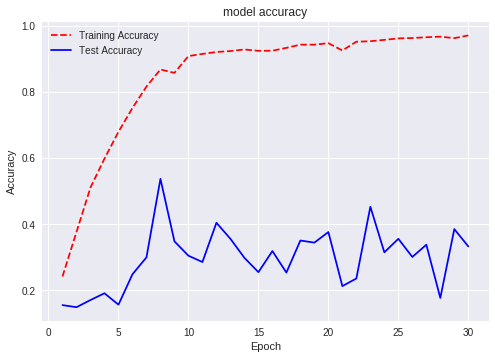

In [48]:
visualize.plot_train_test_acc(history=history)

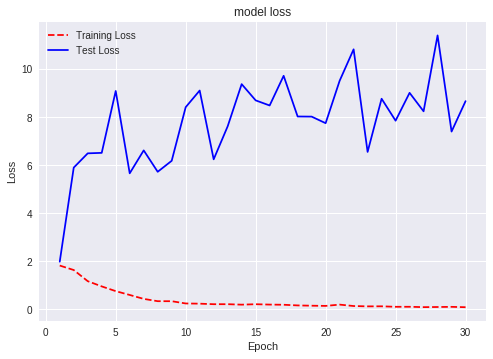

In [49]:
visualize.plot_train_test_loss(history=history)

In [50]:
correct = 0
wrong = 0
for val_file in partition["validation"]:
    val_data = abs(np.load(DATA_PATH + val_file))
    val_1 = np.expand_dims(val_data, 0)
    prediction = model.predict(val_1)[0]
#     print("Actual:", labels[val_file], "Predicted:", np.argmax(prediction))
    if int(labels[val_file]) == int(np.argmax(prediction)):
        correct += 1
    else:
        wrong += 1
print("correct:", correct, "wrong:", wrong)        

ValueError: ignored

In [0]:
for counter, val_file in enumerate(partition["train"]):
#     if counter > 200:
#         break
#     if counter < 40:
#         continue
    val_data = abs(np.load(DATA_PATH + val_file))
    val_1 = np.expand_dims(val_data, 0)
    prediction = model.predict(val_1)[0]
#     print("Actual:", labels[val_file], "Predicted:", np.argmax(prediction))
    if int(labels[val_file]) == int(np.argmax(prediction)):
        correct += 1
    else:
        wrong += 1
print("correct:", correct, "wrong:", wrong)        